In [1]:
# bibliotecas default
import pandas as pd
import numpy as np

# bibliotecas para visualização dos dados
import seaborn as sns
import matplotlib.pyplot as plt

# bibliotecas para transformação e tratamento dos dados
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# importando os classificadares
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

**Importando o *utils* fornecido pelo professor.**

In [2]:
from utils import imprimir_estatisticas, calcular_estatisticas, rejeitar_hip_nula
from mixins import selecionar_melhor_modelo, do_cv

#### Lendo os arquivo de Teste e Treino em um *dataframe*

In [3]:
df_test = pd.read_csv("titanic/test.csv")
df_train = pd.read_csv("titanic/train.csv")

In [4]:
df_train_new = df_train.drop(columns=["PassengerId", "Name"])

In [5]:
df_train_new = df_train_new.dropna(subset=['Embarked'])

In [6]:
X_train = df_train_new.drop(columns=["Survived"])
Y_train = df_train_new[["Survived"]]

In [7]:
# pega os nomes das colunas
attributes = list(X_train.columns)
# as colunas que vão ser tranformadas
attributes_transf = ['Age', 'Cabin']
# separa as colunas das colunas que serão tranformadas
attributes = [item for item in attributes if item not in attributes_transf]

transformers = [
    ('imp_num', SimpleImputer(strategy='mean'), ['Age']),
    ('imp_cat', SimpleImputer(strategy='constant', fill_value='Unknown'), ['Cabin'])
]

col_trans = ColumnTransformer(
    transformers, remainder='passthrough', sparse_threshold=0
)
values_imput = col_trans.fit_transform(X_train)
values_imput

array([[22.0, 'Unknown', 3, ..., 'A/5 21171', 7.25, 'S'],
       [38.0, 'C85', 1, ..., 'PC 17599', 71.2833, 'C'],
       [26.0, 'Unknown', 3, ..., 'STON/O2. 3101282', 7.925, 'S'],
       ...,
       [29.64209269662921, 'Unknown', 3, ..., 'W./C. 6607', 23.45, 'S'],
       [26.0, 'C148', 1, ..., '111369', 30.0, 'C'],
       [32.0, 'Unknown', 3, ..., '370376', 7.75, 'Q']], dtype=object)

Verificando se tudo ocorreu conforme o planejado.

In [8]:
X_imput = pd.DataFrame(values_imput, columns=[*attributes_transf, *attributes])
X_imput

,Age,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Embarked
0,22.0,Unknown,3,male,1,0,A/5 21171,7.25,S
1,38.0,C85,1,female,1,0,PC 17599,71.2833,C
2,26.0,Unknown,3,female,0,0,STON/O2. 3101282,7.925,S
3,35.0,C123,1,female,1,0,113803,53.1,S
4,35.0,Unknown,3,male,0,0,373450,8.05,S
...,...,...,...,...,...,...,...,...,...
884,27.0,Unknown,2,male,0,0,211536,13.0,S
885,19.0,B42,1,female,0,0,112053,30.0,S
886,29.642093,Unknown,3,female,1,2,W./C. 6607,23.45,S
887,26.0,C148,1,male,0,0,111369,30.0,C


In [9]:
X_imput['Cabin'] = X_imput['Cabin'].apply(lambda x: 'Known' if x != 'Unknown' else 'Unknown')

In [10]:
X_imput['Age'] = X_imput['Age'].apply(lambda x: round(x))
X_imput = X_imput.drop(columns=["Embarked", "Age"])

In [11]:
X_imput.head(2)

,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare
0,Unknown,3,male,1,0,A/5 21171,7.25
1,Known,1,female,1,0,PC 17599,71.2833


In [12]:
transformers = [
    ('ohe_sex', OneHotEncoder(), ['Sex']),
    ('oe_cabin', OneHotEncoder(), ['Cabin']),
    ('oe_ticket', OneHotEncoder(), ['Ticket'])
]

col_trans = ColumnTransformer(
    transformers, remainder='passthrough', sparse_threshold=0
)

col_trans.fit(X_imput)
X_trans = col_trans.transform(X_imput)
X_trans

array([[0.0, 1.0, 0.0, ..., 1, 0, 7.25],
       [1.0, 0.0, 1.0, ..., 1, 0, 71.2833],
       [1.0, 0.0, 0.0, ..., 0, 0, 7.925],
       ...,
       [1.0, 0.0, 0.0, ..., 1, 2, 23.45],
       [0.0, 1.0, 1.0, ..., 0, 0, 30.0],
       [0.0, 1.0, 0.0, ..., 0, 0, 7.75]], dtype=object)

In [13]:
X_trans = pd.DataFrame(X_trans, columns=col_trans.get_feature_names())
X_trans

,ohe_sex__x0_female,ohe_sex__x0_male,oe_cabin__x0_Known,oe_cabin__x0_Unknown,oe_ticket__x0_110152,oe_ticket__x0_110413,oe_ticket__x0_110465,oe_ticket__x0_110564,oe_ticket__x0_110813,oe_ticket__x0_111240,...,oe_ticket__x0_W./C. 6607,oe_ticket__x0_W./C. 6608,oe_ticket__x0_W./C. 6609,oe_ticket__x0_W.E.P. 5734,oe_ticket__x0_W/C 14208,oe_ticket__x0_WE/P 5735,Pclass,SibSp,Parch,Fare
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,1,0,7.25
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,71.2833
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,7.925
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0,53.1
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,8.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,13.0
885,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30.0
886,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,3,1,2,23.45
887,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,30.0


In [14]:
new_df = X_imput
new_df['Survived'] = Y_train
new_df['Survived'] = new_df['Survived'].apply(lambda x: 'Yes' if x == 1 else 'No')
new_df

,Cabin,Pclass,Sex,SibSp,Parch,Ticket,Fare,Survived
0,Unknown,3,male,1,0,A/5 21171,7.25,No
1,Known,1,female,1,0,PC 17599,71.2833,Yes
2,Unknown,3,female,0,0,STON/O2. 3101282,7.925,Yes
3,Known,1,female,1,0,113803,53.1,Yes
4,Unknown,3,male,0,0,373450,8.05,No
...,...,...,...,...,...,...,...,...
884,Unknown,2,male,0,0,211536,13.0,No
885,Known,1,female,0,0,112053,30.0,No
886,Unknown,3,female,1,2,W./C. 6607,23.45,No
887,Known,1,male,0,0,111369,30.0,Yes


In [15]:
ss = StandardScaler()
ss.fit(X_trans)
X_ss = ss.transform(X_trans)

In [16]:
np.max(X_ss), np.min(X_ss)

(29.79932885150268, -1.8441773502052077)

In [17]:
pca = PCA(n_components=2)
pca.fit(X_ss)

PCA(n_components=2)

In [18]:
X_pca = pca.transform(X_ss)
X_pca

array([[-1.73084462, -0.54209017],
       [ 4.02223484,  0.40150412],
       [-0.64178199,  1.83640941],
       ...,
       [-0.27261766,  3.06990085],
       [ 2.47390042, -2.82969908],
       [-1.76994382, -0.95510637]])

In [19]:
X_pca_df = pd.DataFrame(X_pca, columns=['PC 00', 'PC 01'])
X_pca_df

,PC 00,PC 01
0,-1.730845,-0.542090
1,4.022235,0.401504
2,-0.641782,1.836409
3,3.720994,-0.086686
4,-1.767261,-0.956516
...,...,...
884,-1.082838,-1.257071
885,3.600448,-0.043047
886,-0.272618,3.069901
887,2.473900,-2.829699


<AxesSubplot:xlabel='PC 00', ylabel='PC 01'>

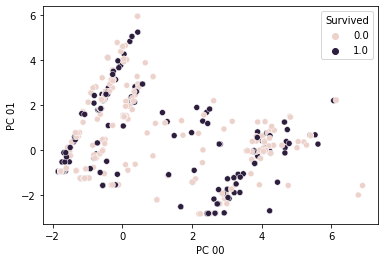

In [20]:
# 0 = No, 1 = Yes
sns.scatterplot(data=X_pca_df, x='PC 00', y='PC 01', hue=Y_train['Survived'])

 ## Classificando os dados com classificadores diferentes

In [21]:
rf_test = ('rf', RandomForestClassifier, False, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
ad_def_test = ('ad_default', DecisionTreeClassifier, False, {'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
ad_tuned_test = ('ad_tuned', DecisionTreeClassifier, False, {'min_samples_leaf' : [3, 5, 10, 15, 20, 30],
                                                 'min_samples_split' : [2, 4, 8, 16, 32, 40],
                                                 'max_depth' : [None, 2, 3, 4, 5],
                                                 'criterion' : ['gini', 'entropy'], 'random_state' : [1]})
svm_test = ('svm', SVC, True, {'C' : [1, 10, 100, 1000], 'gamma' : ['auto', 'scale']})
knn_test = ('knn', KNeighborsClassifier, True, {'n_neighbors' : range(1,30,2)})

tests = [rf_test, ad_def_test, ad_tuned_test, svm_test, knn_test]

In [22]:
y = Y_train['Survived'].values.ravel()

In [23]:
resultados = {}
for nome, classificador, scale, params in tests:
    r = do_cv(classificador, X_pca_df.values, y, 10, 10, 8, scale, params)
    resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
for teste in resultados:
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

        rf - Resultados: 0.71 +- 0.07, min: 0.55, max: 0.79
ad_default - Resultados: 0.67 +- 0.07, min: 0.52, max: 0.74
  ad_tuned - Resultados: 0.68 +- 0.06, min: 0.53, max: 0.74
       svm - Resultados: 0.71 +- 0.06, min: 0.59, max: 0.83
       knn - Resultados: 0.70 +- 0.05, min: 0.63, max: 0.77


In [25]:
resultados = {}
for nome, classificador, scale, params in tests:
    r = do_cv(classificador, X_ss, y, 10, 10, 8, scale, params)
    resultados[nome] = r

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [26]:
for teste in resultados:
    print(teste.rjust(10), end=' - ')
    imprimir_estatisticas(resultados[teste])

        rf - Resultados: 0.75 +- 0.08, min: 0.59, max: 0.86
ad_default - Resultados: 0.78 +- 0.05, min: 0.67, max: 0.87
  ad_tuned - Resultados: 0.72 +- 0.06, min: 0.60, max: 0.79
       svm - Resultados: 0.54 +- 0.10, min: 0.33, max: 0.67
       knn - Resultados: 0.55 +- 0.03, min: 0.49, max: 0.59
